In [1]:
import os, sys
import re
import random
import numpy as np
import scipy as sc
import pickle as pkl
import matplotlib.pyplot as plt
import tqdm

from pathlib import Path
import IPython
import librosa
from librosa import display
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets.samples_generator import make_blobs
from sklearn import svm, metrics

from itertools import product
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image
sys.path.insert(0, os.path.join("..", "src"))
from MultiClassSVM import *
from OneVsAllClassifier import *
from DecisionTree import *
from GradientBoosting import *
from utils import pseudo_residual_L2, pseudo_residual_logistic

%matplotlib inline

# Problem 1

The hinge loss penalty is defined as 
$$\ell_1(h, (x_i,y_i)) = \max_{y\in \mathcal{Y}\backslash \{y_i\}}\left(\Delta(y_i,y)-m_{i,y}(h)\right)_+ $$
while the generalized hinge loss is defined as 
$$\ell_2(h, (x_i,y_i)) = \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]$$

## 1.1

Supposing $\Delta(y,y) = 0$ then 
\begin{align*}
\ell_2(h, (x_i,y_i)) &= \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]\\
&= \max \left(\Delta(y_i,y_i) + h(x_i,y_i) - h(x_i,y_i), \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]\right)\\
&= \max \left(0, \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]\right)\\
&= \max \left(0, \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)-m_{i,y}(h)\right]\right)\\
&= \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)-m_{i,y}(h)\right]_+\\
\end{align*}

## 1.2

Supposing $m_{i,y}(h) = h(x_i,y_i)-h(x_i,y) \ge \Delta(y_i,y)$ then $\Delta(y_i,y) -m_{i,y}(h) \le 0$ which implies $\ell_1(h,(x_i,y_i))=0$. This further implies $\ell_1(h,(x_i,y_i))=0$

Under the above conditions, since $h(x_i,y_i)-h(x_i,y)\gt 0$ then $h(x_i,y_i)\gt h(x_i,y)$ we must have that $y_i = \arg \max h(x_i,y)$ which means we make a correct prediction.

# Problem 2

The $\ell_2$ regularized loss function is given by 
$$J(w) = \lambda \|w\|^2 + \frac{1}{n} \sum_{i=1}^n \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y) + \langle w, \Psi(x_i,y)-\Psi(x_i,y_i)\rangle\right]$$

## Problem 2.1

The function $J(w)$ is convex since the first term is the sum of squares and the second terms is the pointwise maximum of an affine function of $w$. Since affine functions are convex, the pointwise maximum of convex functions is convex, and the sum of convex functions is convex, then $J(w)$ is convex.

## Problem 2.2

A subgradient of $J(w)$ is given by 
$$2\lambda w + 1/n\sum_{i=1}^n \Psi(x_i,\hat{y}_i) - \Psi(x_i,y_i)$$ where $\hat{y}_i = \arg \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y) + \langle w, \Psi(x_i,y)-\Psi(x_i,y_i)\rangle\right]$

# Problem 3

Given $\mathcal{Y} = \{-1,1\}$ and $\Delta(y,\hat{y})=\mathbf{1}(y\ne\hat{y})$ as well as the compatibility score functions $h(x,1) = g(x)/2$ and $h(x,-1)=-g(x)/2$ the multiclass hinge loss is given by 

\begin{align*}
\ell(h,(x,y)) &= \max_{y'\in\mathcal{Y}}\left[\Delta(y,y') + h(x,y')-h(x,y)\right]\\
&= \max\left(\Delta(y,-1) + h(x,-1)-h(x,y), \Delta(y,1) + h(x,1)-h(x,y)\right)\\
&= \max\left(\Delta(y,-1) -g(x)/2-yg(x)/2, \Delta(y,1) + g(x)/2-yg(x)/2\right)\\
&= \max\left\{0,1-yg(x)\right\}\\
\end{align*}


# Problem 4

## 4.1

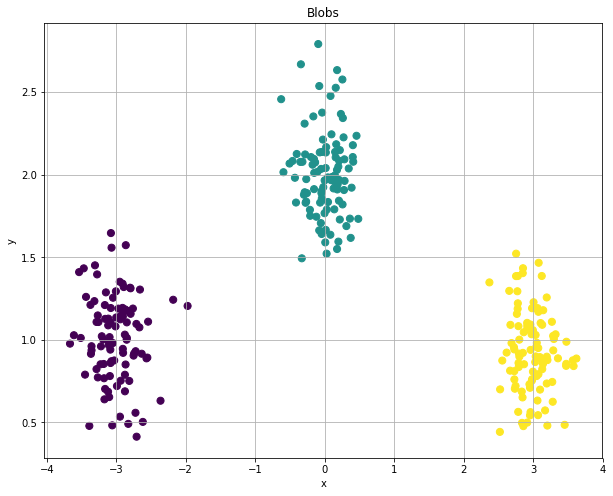

In [20]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(
    n_samples=300,
    cluster_std=.25,
    centers=np.array([(-3,1),(0,2),(3,1)])
)

plt.figure(figsize=(10,8));
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);
plt.grid(True);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Blobs");

/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Coeffs 0
[[-1.05852747 -0.90296521]]
Coeffs 1
[[ 0.22117096 -0.38900908]]
Coeffs 2
[[ 0.89162796 -0.82467394]]


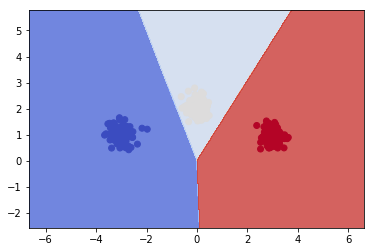

In [24]:
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X, y)

for i in range(3) :
    print(f"Coeffs {i}")
    print(clf_onevsall.estimators[i].coef_)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0]) - 3, max(X[:,0]) + 3
y_min, y_max = min(X[:,1]) - 3, max(X[:,1]) + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

In [26]:
metrics.confusion_matrix(y, clf_onevsall.predict(X))

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

## 4.2

w: [-5.14748980e-10  3.01805016e-12 -2.00932911e-10  3.29705584e-10
  7.15681891e-10 -3.32723634e-10]


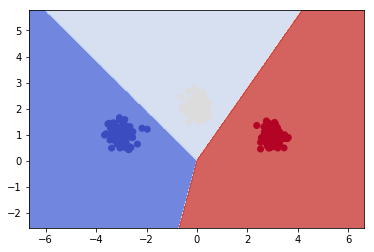

In [27]:
est = MulticlassSVM(6, lam=1)
est.fit(X, y, epochs=2000)
print(f"w: {est.coef_}")
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8);

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

In [28]:
metrics.confusion_matrix(y, est.predict(X))

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

# Problem 5

In [2]:
audio_folder = Path("..", "data", "UrbanSound8K", "audio")
class_dirs = os.listdir(audio_folder)

class_to_file = {}
for d in class_dirs:
    match = re.search("^fold([0-9]+)", d)
    if not match:
        continue
    candidate_files = os.listdir(audio_folder / d)
    rand_sound_file = random.choice(candidate_files)
    if rand_sound_file is not None:
        label = int(match.groups()[0])
        class_to_file[label] = (audio_folder / d /rand_sound_file).absolute()

In [3]:
X = {}
for key, val in class_to_file.items():
    signal, fs = librosa.load(val)
    X[key] = signal

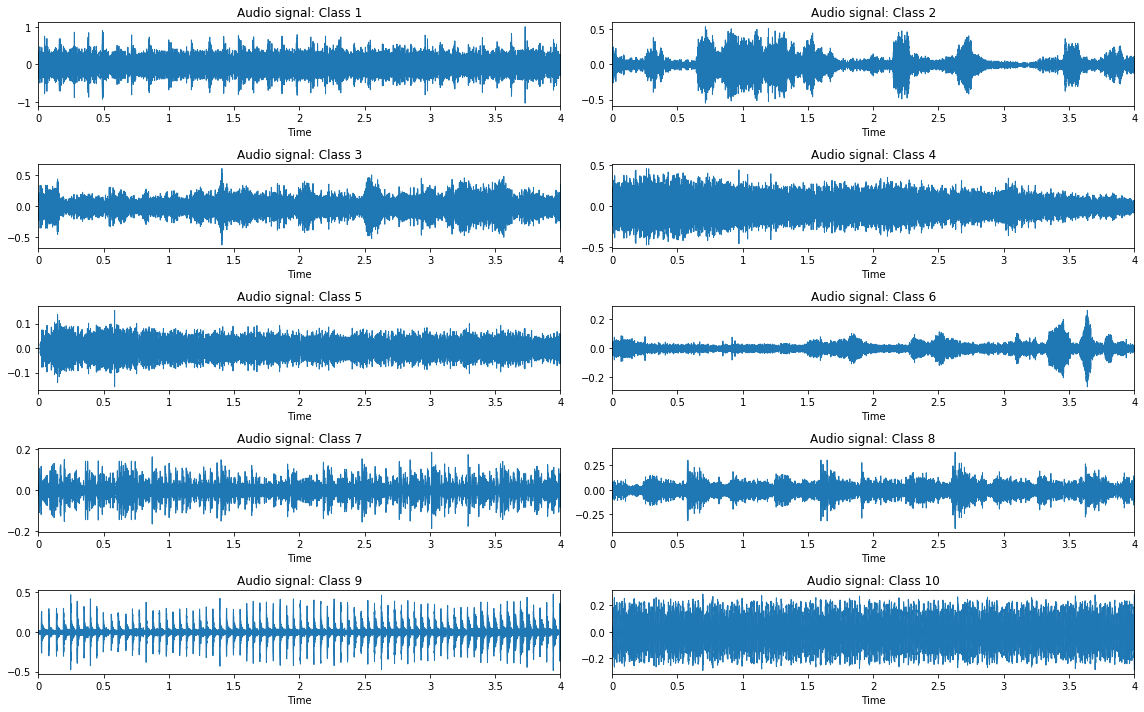

In [4]:
plt.figure(figsize=(16,10))

for i in range(1,11):
    plt.subplot(5, 2, i)
    display.waveplot(X[i], sr=fs);
    plt.title(f"Audio signal: Class {i}");
plt.tight_layout()

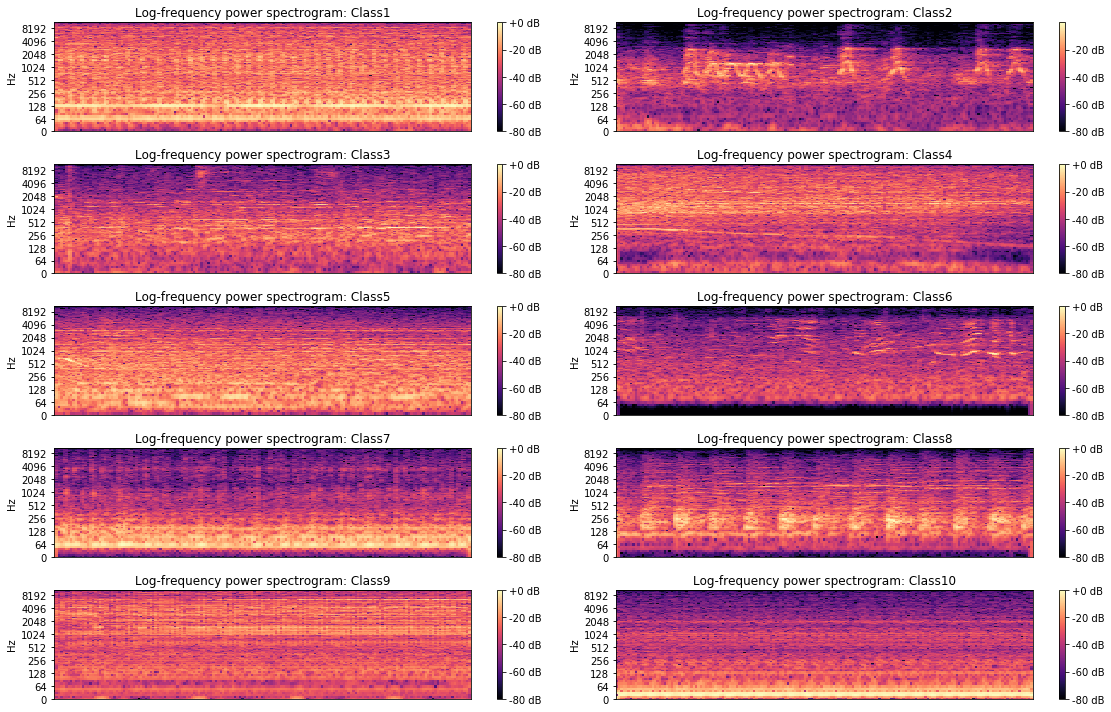

In [5]:
plt.figure(figsize=(16,10))

for i in range(1, 11):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(X[i])), ref=np.max)
    plt.subplot(5, 2, i)
    display.specshow(D, y_axis="log");
    plt.colorbar(format="%+2.0f dB");
    plt.title(f"Log-frequency power spectrogram: Class{i}");
plt.tight_layout()

In [6]:
IPython.display.Audio(X[5], rate=fs)

In [7]:
IPython.display.Audio(X[8], rate=fs)

In [8]:
data_folder = Path("..", "data", "UrbanSound8K", "audio")

try:
    with open(data_folder / "raw_sound_data.pkl", "rb") as f:
        X_data = pkl.load(f)
except:
    X_data = []
    for i in range(1,11):
        class_folder = data_folder / f"fold{i}"
        class_files = os.listdir(class_folder)
        class_data = []
        for fname in tqdm.tqdm(class_files):
            try:
                _, ext = os.path.splitext(fname)
                if ext != ".wav":
                    continue
                signal, fs = librosa.load(class_folder / fname)
                class_data.append(signal)
            except: 
                print(f"Unable to load {fname}")
        X_data.append(class_data)
    with open(data_folder / "raw_sound_data.pkl", "wb") as f:
        pkl.dump(X_data, f)
#     librosa.feature.mfcc(X[i])

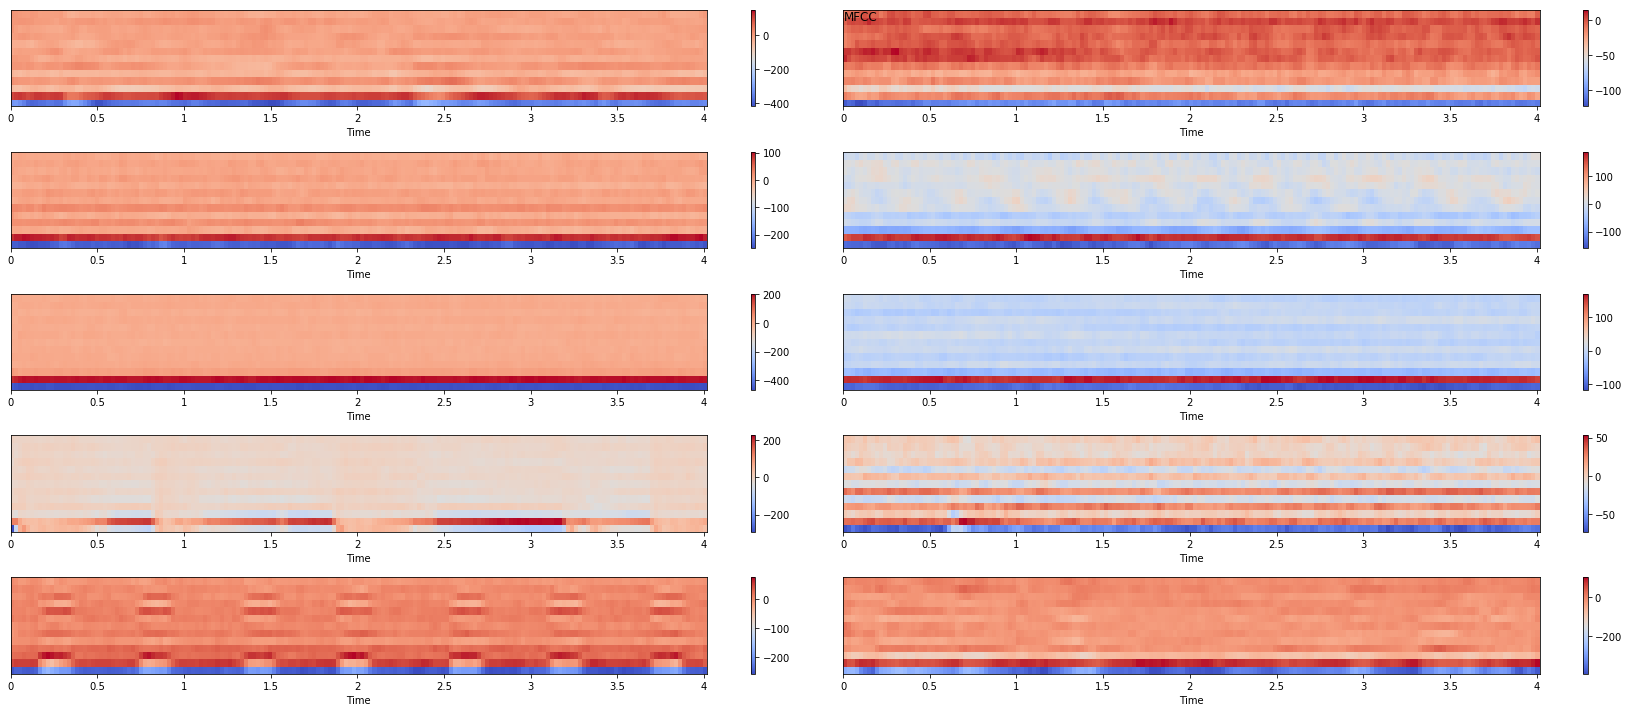

In [36]:
plt.figure(figsize=(24,10))
X_cepstral = []
y_label = []
for i, class_data in enumerate(X_data):
    for j, signal in enumerate(class_data):
        mfcc_feats = librosa.feature.mfcc(signal, n_mfcc=13)
#         mfcc_first_diff = librosa.feature.delta(mfcc_feats, order=1)
#         mfcc_second_diff = librosa.feature.delta(mfcc_feats, order=2)
        max_mfcc = np.max(mfcc_feats, axis=1)
        min_mfcc = np.min(mfcc_feats, axis=1)
        mean_mfcc = np.mean(mfcc_feats, axis=1)
        stddev_mfcc = np.std(mfcc_feats, axis=1)
        X_cepstral.append(np.hstack([min_mfcc, max_mfcc, mean_mfcc, stddev_mfcc]))
        y_label.append(j + 1)
    plt.subplot(5, 2, i + 1)
    display.specshow(mfcc_feats, x_axis="time")
    plt.colorbar()
plt.suptitle("MFCC")
plt.tight_layout()

In [37]:
X = np.stack(X_cepstral)
y = np.array(y_label)

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
RandomizedSearchCV()

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_distributions'

In [51]:
model = SVC()
grid_params = {
    "C": scipy.stats.expon(scale=1), 
    "gamma": sc.stats.expon(scale=1),
    "kernel": ["rbf"], 
}

In [53]:
rgrid = RandomSearchCV(estimator=model, param_grid=grid_params)

NameError: name 'RandomSearchCV' is not defined

In [26]:
rgrid.fit(X_train, y_train)

In [ ]:
print(rgrid.best_score_)
print(rgrid.best_estimator_.alpha)

# Problem 6

## Load Data

In [2]:
data_dir = os.path.join("..", "data")
data_train = np.loadtxt(os.path.join(data_dir, "svm-train.txt"))
data_test = np.loadtxt(os.path.join(data_dir, "svm-test.txt"))

x_train, y_train = data_train[:, 0:2], data_train[:, 2]
x_test, y_test = data_test[:, 0:2], data_test[:, 2]

In [3]:
# Change target to 0-1 label
y_train_label = np.array([1 if label > 0 else 0 for label in y_train])
y_test_label = np.array([1 if label > 0 else 0 for label in y_test])

## Decision Tree Boundary

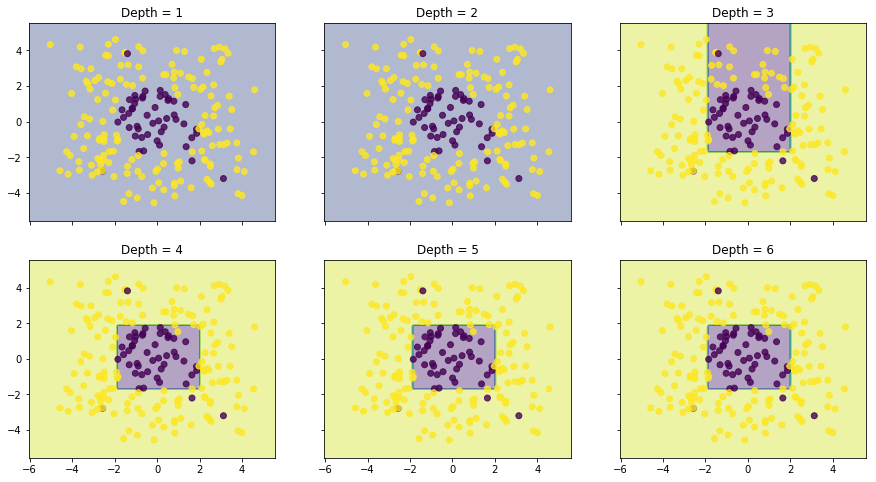

In [4]:
# Training classifiers with different depth
clf1 = ClassificationTree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = ClassificationTree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = ClassificationTree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = ClassificationTree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = ClassificationTree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = ClassificationTree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        [f"Depth = {n}" for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    curr_axis = axarr[idx[0], idx[1]]

    curr_axis.contourf(xx, yy, Z, alpha=0.4)
    curr_axis.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    curr_axis.set_title(tt)

plt.show()

## Compare decision tree with tree model in sklearn

In [5]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file="tree_classifier.dot")

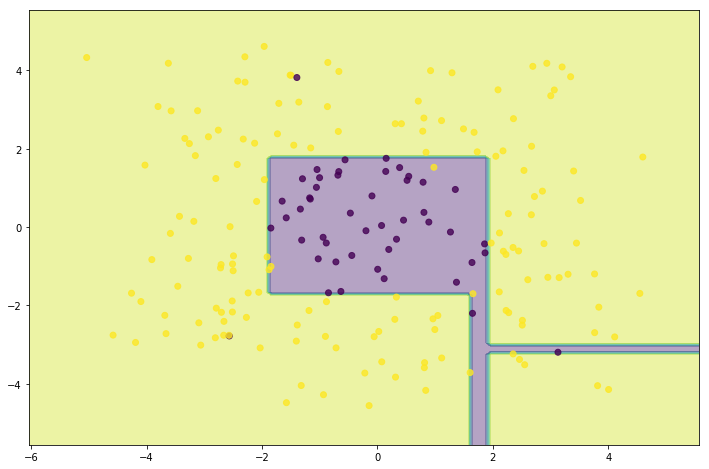

In [6]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
plt.show()
# curr_axis.set_title(tt)

In [28]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

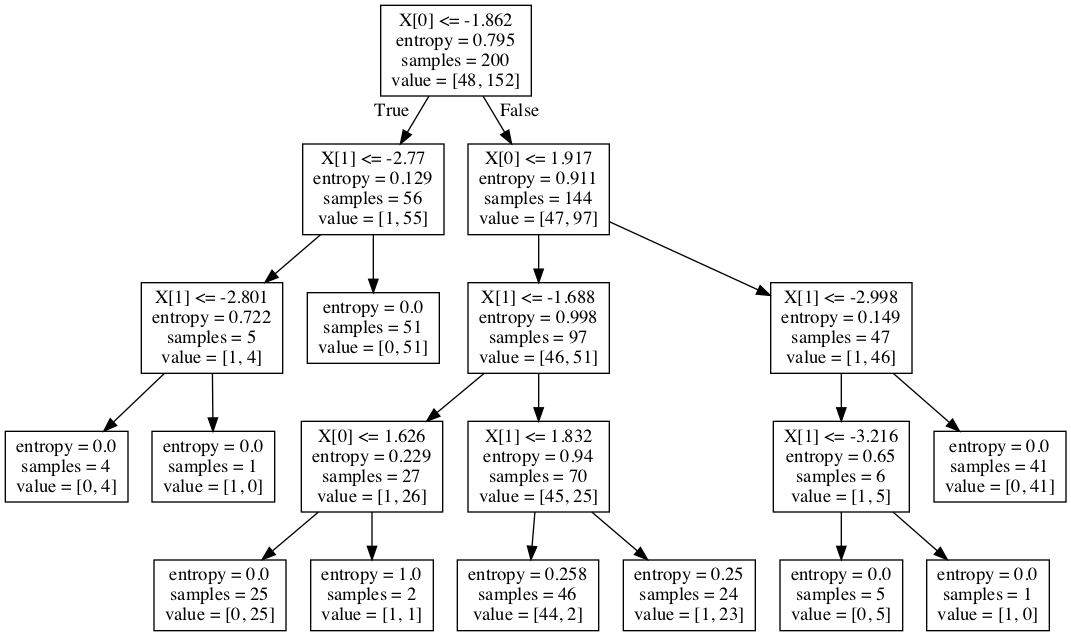

In [29]:
Image(filename="tree_classifier.png")

## Fit regression tree to one-dimensional regression data

/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


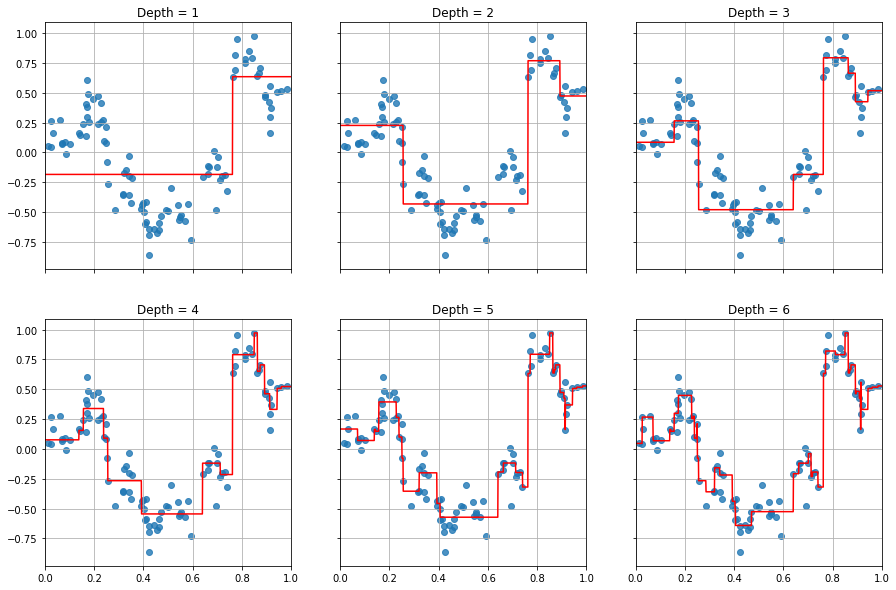

In [7]:
data_krr_train = np.loadtxt(os.path.join(data_dir, "krr-train.txt"))
data_krr_test = np.loadtxt(os.path.join(data_dir, "krr-test.txt"))

x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1), data_krr_train[:,1]
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1), data_krr_test[:,1]

# Training regression trees with different depth
clf1 = RegressionTree(max_depth=1,  min_sample=1, loss_function="mae", estimator="median")
clf1.fit(x_krr_train, y_krr_train)

clf2 = RegressionTree(max_depth=2,  min_sample=1, loss_function="mae", estimator="median")
clf2.fit(x_krr_train, y_krr_train)

clf3 = RegressionTree(max_depth=3,  min_sample=1, loss_function="mae", estimator="median")
clf3.fit(x_krr_train, y_krr_train)

clf4 = RegressionTree(max_depth=4,  min_sample=1, loss_function="mae", estimator="median")
clf4.fit(x_krr_train, y_krr_train)

clf5 = RegressionTree(max_depth=5,  min_sample=1, loss_function="mae", estimator="median")
clf5.fit(x_krr_train, y_krr_train)

clf6 = RegressionTree(max_depth=6,  min_sample=1, loss_function="mae", estimator="median")
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        [f"Depth = {n}" for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    curr_axis = axarr2[idx[0], idx[1]]

    curr_axis.plot(x_range, y_range_predict, color="r")
    curr_axis.scatter(x_krr_train, y_krr_train, alpha=0.8)
    curr_axis.set_title(tt)
    curr_axis.set_xlim(0, 1)
    curr_axis.grid(True)
plt.show()

# Problem 7

Consider the loss function given by $\ell(\hat{y}, y) = 1/2(\hat{y}-y)^2$. At the beginning of the $m$'th round of gradient boosting, we have the prediction function $f_{m-1}(x)$. To perform the next round of gradient boosting, we find the negative gradient of the loss function wrt each $f_{m-1}(x_i)$ which is given by $-(g_m)_i = -f_{m-1}(x_i) + y_i$.

We then solve the optimization problem 
$$\arg \min_{h\in \mathcal{F}} \sum_{i=1}^N ([y_i - f_{m-1}(x_i)] - h(x_i))^2$$
to fit a new function to the negative gradients of each example

In the classification case we have $\mathcal{Y} = \{-1,1\}$. Considering the logistic loss 
$$\ell(y, \hat{y}) = \log(1 + e^{-y\hat{y}})$$
Given the function $f_{m-1}(x)$ from $m-1$ iterations of gradient boosting we can find the gradient wrt each $f_{m-1}(x_i)$ which is given by $(g_m)_i = -y_i\frac{e^{-y_if_{m-1}(x_i)}}{1 + e^{-y_if_{m-1}(x_i)}} = -y_i\sigma(-y_if_{m-1}(x_i))$

Solving the optimization problem
$$h_m = \arg \min_{h\in \mathcal{F}} \sum_{i=1}^N\left(y_i\sigma(-y_if_{m-1}(x_i)) - h(x_i)\right)^2$$

gives the new function to add to $f_{m-1}(x)$

# Problem 8

## 2-D GBM visualization - SVM data

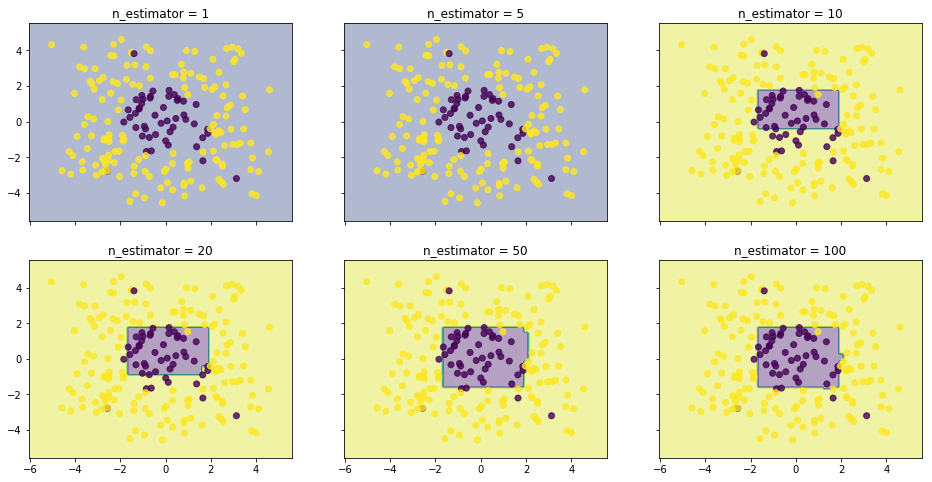

In [8]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(16, 8))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    
    gbt = GradientBoosting(n_estimator=n, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
  
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    curr_axis = axarr[idx[0], idx[1]]

    curr_axis.contourf(xx, yy, Z, alpha=0.4)
    curr_axis.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")


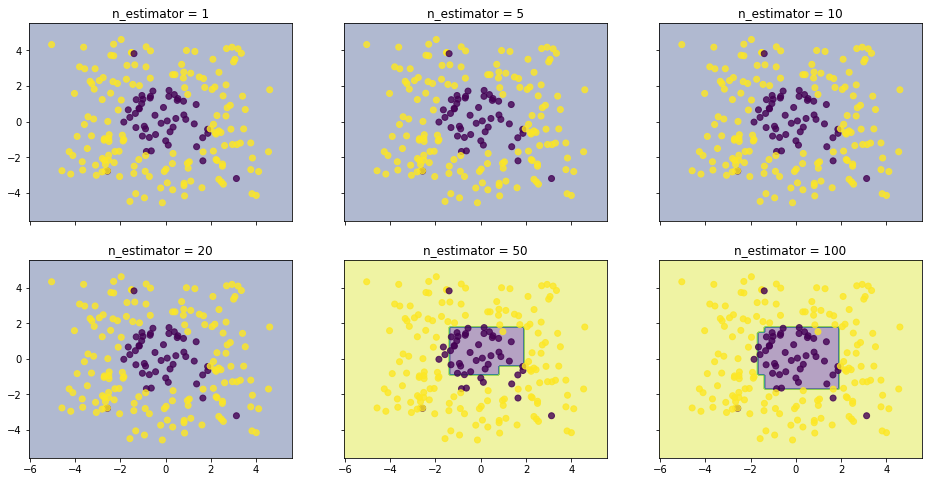

In [9]:
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(16, 8))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    
    gbt = GradientBoosting(n_estimator=n, pseudo_residual_func=pseudo_residual_logistic, max_depth=2)  
    gbt.fit(x_train, 2*y_train_label-1)
#     gbt.fit(x_train, y_train)

    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    curr_axis = axarr[idx[0], idx[1]]
    curr_axis.contourf(xx, yy, Z, alpha=0.4)
    curr_axis.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")


## 1-D GBM visualization - KRR data

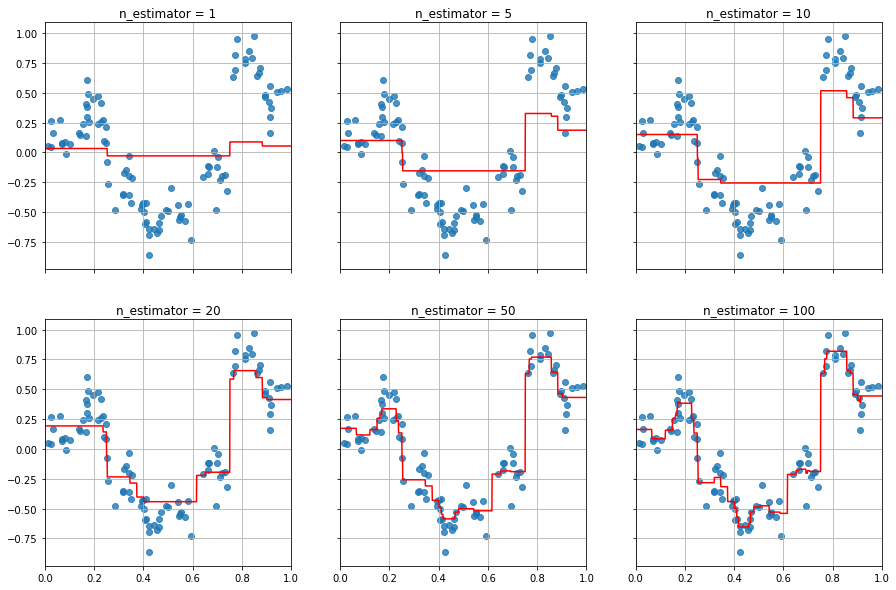

In [10]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 10))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    
    gbm_1d = GradientBoosting(n_estimator=n, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)
    curr_axis = axarr2[idx[0], idx[1]]

    curr_axis.plot(x_range, y_range_predict, color="r")
    curr_axis.scatter(x_krr_train, y_krr_train, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")
    curr_axis.set_xlim(0, 1)
    curr_axis.grid(True)

# Compare with _sklearn_ GradientBoosting

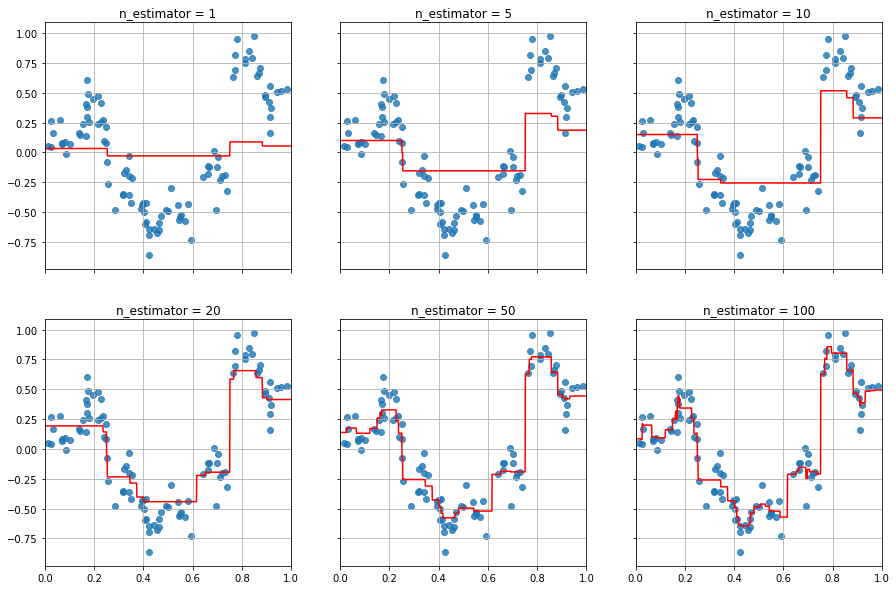

In [11]:
from sklearn import ensemble
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 10))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    params = {
        "n_estimators": n,
        "max_depth": 2,
        "learning_rate": 0.1,
        "criterion": "mse",
    }

    gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)
    gradient_boosting_regressor.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gradient_boosting_regressor.predict(x_range)
    curr_axis = axarr2[idx[0], idx[1]]

    curr_axis.plot(x_range, y_range_predict, color="r")
    curr_axis.scatter(x_krr_train, y_krr_train, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")
    curr_axis.set_xlim(0, 1)
    curr_axis.grid(True)